<a href="https://colab.research.google.com/github/rlathwls03/sensor-activity-classifier/blob/main/1_%ED%83%90%EC%83%89%EC%A0%81_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project1 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/project2/'

%cd '/content/drive/MyDrive/project2/'
!ls

/content/drive/MyDrive/project2
'1.탐색적 데이터 분석.ipynb'	        data01_train.csv
'1.탐색적 데이터 분석_추가과제.ipynb'   desktop.ini
'2.기본 모델링.ipynb'		        feature_importance_all.pkl
'3.단계별 모델링.ipynb'		        features.csv
'AI 미프 1차 과제2_OO반_OO조.pptx'     'features 설명.xlsx'
 data01_test.csv


### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩
    - pandas, numpy,matplotlib,seaborn, joblib 을 로딩하고
    필요한 라이브러리를 로딩합니다.
    <br>(분류 모델에서는 이번에 RandomForestClassifier를 씁니다. 더 많은 분류 모델을 써도 됩니다!)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns)
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [ ]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [ ]:
# 주어진 데이터 셋을 불러오세요.
train = pd.read_csv('data01_train.csv')
test = pd.read_csv('data01_test.csv')
features = pd.read_csv('features.csv')

train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


In [ ]:
#불필요한 칼럼을 삭제하세요.
# subject 칼럼 삭제
train = train.drop(columns=['subject'])
test = test.drop(columns=['subject'])

# subject 칼럼 제거된 것 확인
print(train.head())
print(test.head())

   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288508          -0.009196          -0.103362         -0.988986   
1           0.265757          -0.016576          -0.098163         -0.989551   
2           0.278709          -0.014511          -0.108717         -0.997720   
3           0.289795          -0.035536          -0.150354         -0.231727   
4           0.394807           0.034098           0.091229          0.088489   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.962797         -0.967422         -0.989000         -0.962596   
1         -0.994636         -0.987435         -0.990189         -0.993870   
2         -0.981088         -0.994008         -0.997934         -0.982187   
3         -0.006412         -0.338117         -0.273557          0.014245   
4         -0.106636         -0.388502         -0.010469         -0.109680   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyr

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [ ]:
# 전체 데이터의 행, 열 개수를 확인
print("train 데이터의 shape:", train.shape)
print("test 데이터의 shape:", test.shape)

train 데이터의 shape: (5881, 562)
test 데이터의 shape: (1471, 562)


In [ ]:
# 전체 데이터의 상위 5개 행 확인
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
# 전체 데이터의 수치형 변수 분포 확인
train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [ ]:
#전체 데이터의 모든 변수 확인
print(train.info())
print('-'*30)
print(train.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB
None
------------------------------
Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)


In [ ]:
#(추가) 다양하게 기본 정보들을 확인하세요!

# 결측치 확인
print('결측치 개수:\n', train.isnull().sum().sum())

# 클래스(라벨) 분포 확인
if 'Activity' in train.columns:
  print('\nActivity class 분포:')
  print(train['Activity'].value_counts)

결측치 개수:
 0

Activity class 분포:
<bound method IndexOpsMixin.value_counts of 0                 STANDING
1                   LAYING
2                 STANDING
3                  WALKING
4       WALKING_DOWNSTAIRS
               ...        
5876               SITTING
5877      WALKING_UPSTAIRS
5878                LAYING
5879      WALKING_UPSTAIRS
5880               SITTING
Name: Activity, Length: 5881, dtype: object>


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [ ]:
# 한글 표시를 위해 설치
!pip install koreanize_matplotlib -q
import koreanize_matplotlib

In [ ]:
# Activity 에 대해서 단변량 분석을 시행합니다. (범주별 빈도수, 종류, 비율, 시각화도 해보기!)

Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64


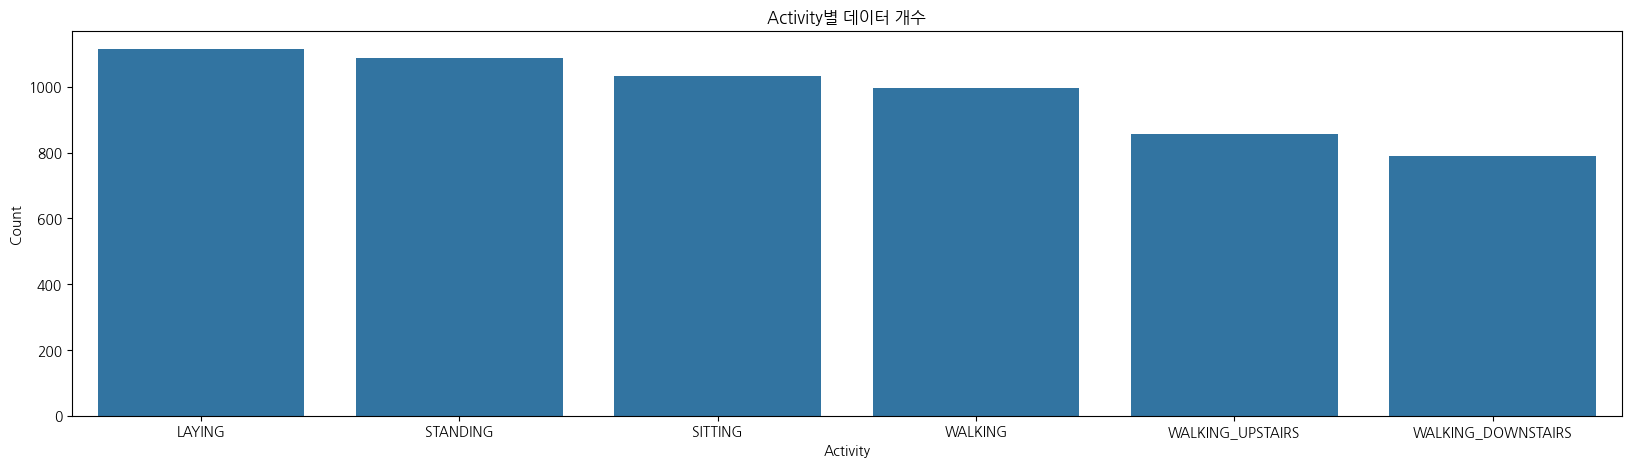

In [ ]:
# Activity별 빈도수
activity_counts = train['Activity'].value_counts()

print(activity_counts)

# 시각화 (barplot)
plt.figure(figsize=(20,5))
sns.countplot(data=train, x='Activity',  order=activity_counts.index)
plt.title('Activity별 데이터 개수')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.show()

In [ ]:
# Activity 종류
train['Activity'].unique()

array(['STANDING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS', 'SITTING'], dtype=object)

Activity
LAYING                18.959361
STANDING              18.483251
SITTING               17.548036
WALKING               16.969903
WALKING_UPSTAIRS      14.589356
WALKING_DOWNSTAIRS    13.450094
Name: proportion, dtype: float64


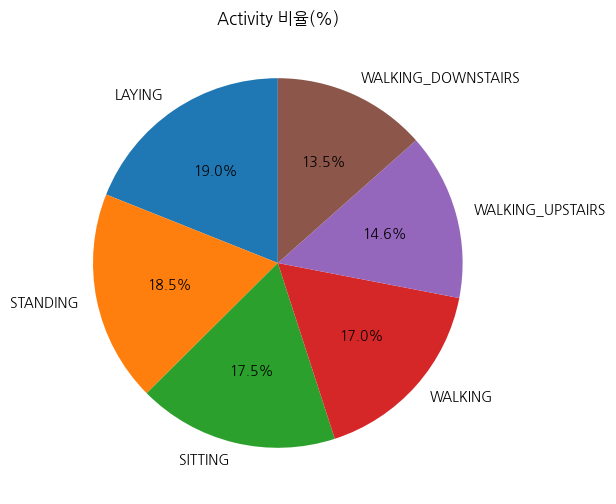

In [ ]:
# Activity별 비율
print(train['Activity'].value_counts(normalize=True)*100)

# 시각화
plt.figure(figsize=(6, 6))
plt.pie(activity_counts, labels=activity_counts.index, autopct='%.1f%%', startangle=90)
plt.title('Activity 비율(%)')
plt.show()

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [ ]:
# 센서 데이터 구조 확인
features.head()

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


In [ ]:
#센서 그룹 데이터의 'sensor'변수의 값 확인
# 변수 종류 및 개수
features['sensor'].value_counts()

,count
sensor,
fBodyGyro,79
fBodyAccJerk,79
fBodyAcc,79
tBodyAcc,40
tGravityAcc,40
tBodyAccJerk,40
tBodyGyroJerk,40
tBodyGyro,40
tGravityAccMag,13


In [ ]:
#센서 그룹 데이터의 'agg'변수의 값 확인
# 변수 종류 및 개수
features['agg'].value_counts()

,count
agg,
bandsEnergy(),126
arCoeff(),60
std(),33
mad(),33
max(),33
energy(),33
min(),33
entropy(),33
iqr(),33


In [ ]:
#센서 그룹 데이터의 'axis'변수의 값 확인
# 변수 종류 및 개수
features['axis'].value_counts()

,count
axis,
X,76
Y,76
Z,76
gravityMean,6
"X,2",5
...,...
"17,32.2",2
"49,64.2",2
"1,24.2",2


## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [ ]:
# 데이터 분할을 위한 전처리

# x, y 분리
x = train.drop('Activity', axis=1)
y = train['Activity']

le = LabelEncoder()
y = le.fit_transform(y)

# 학습/검증 데이터 분할 (8:2)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)

#### 2) 모델링

In [ ]:
#생성

model = RandomForestClassifier(
    n_estimators=200, # 트리 개수
    max_depth=None, # 깊이 제한 없음
    random_state=42,
    n_jobs=-1
)

#학습
model.fit(x_train, y_train)

#예측
y_pred = model.predict(x_val)

#평가
print(accuracy_score(y_val, y_pred))

0.9762107051826678


#### 3) 변수 중요도 추출

,feature_name,feature_importance
0,tGravityAcc-mean()-X,0.033055
1,"angle(X,gravityMean)",0.029547
2,tGravityAcc-min()-X,0.029462
3,tGravityAcc-energy()-X,0.027223
4,tGravityAcc-mean()-Y,0.026683
5,tGravityAcc-min()-Y,0.024566
6,tGravityAcc-max()-X,0.023839
7,"angle(Y,gravityMean)",0.019872
8,tGravityAcc-max()-Y,0.018917
9,tGravityAcc-energy()-Y,0.017316


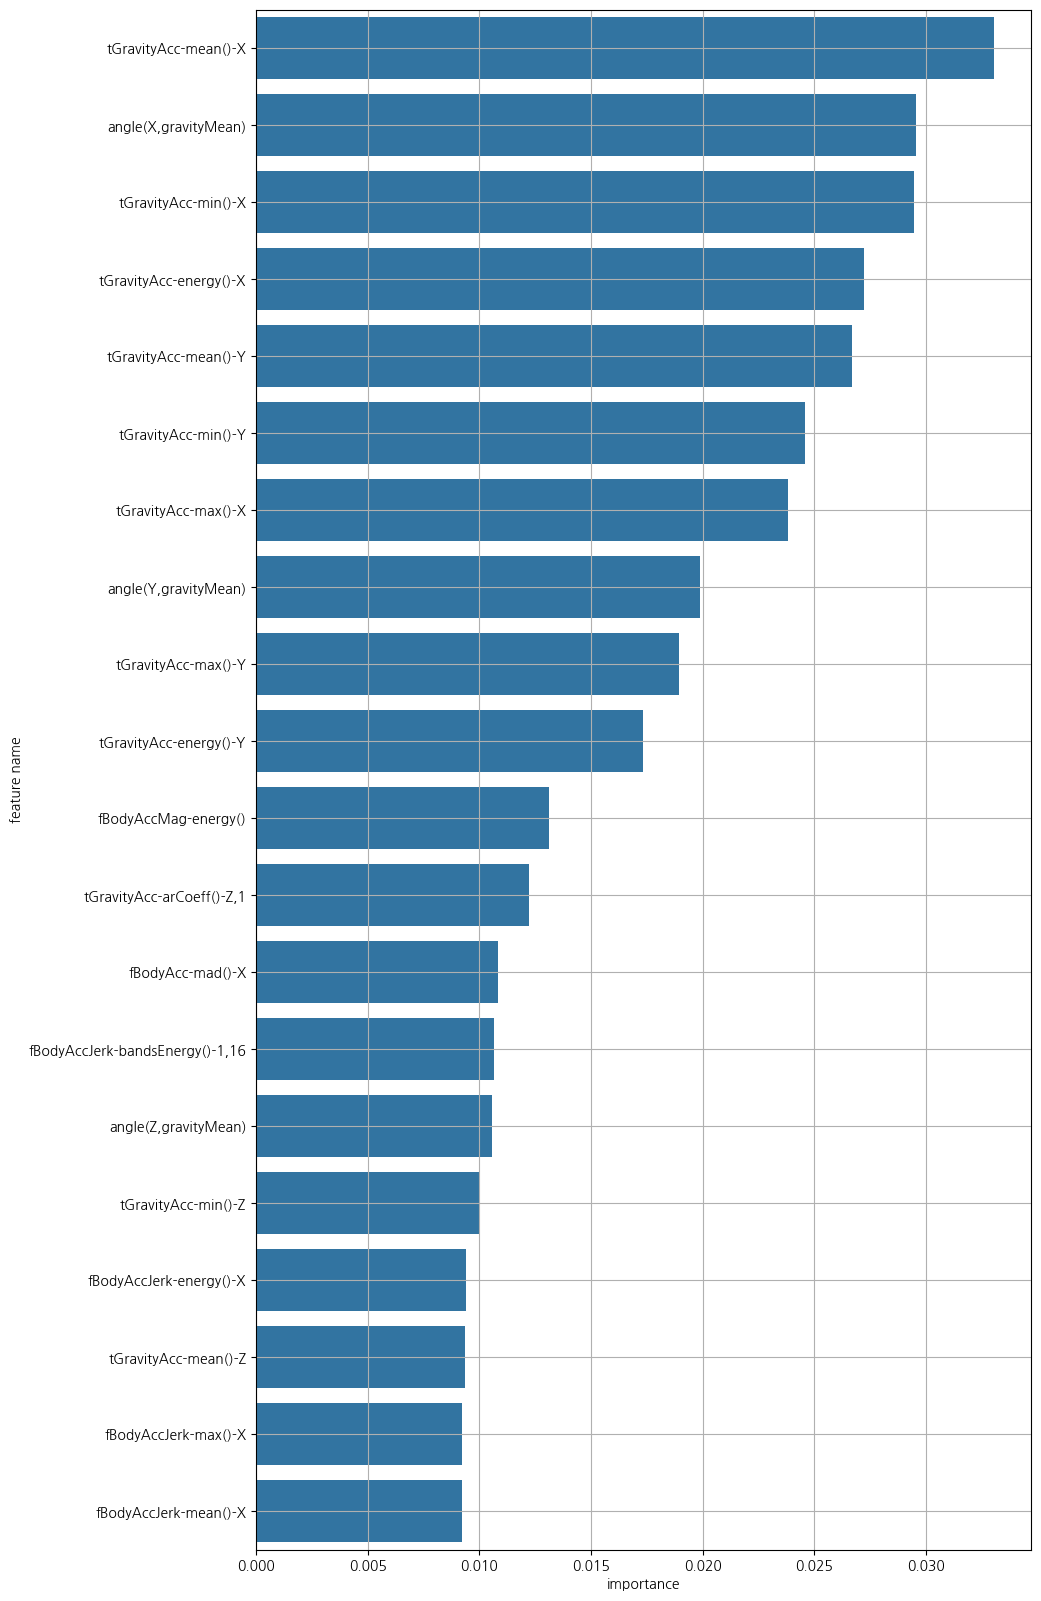

In [ ]:
# 변수 중요도 추출(시각화로 나타내기)
importances = model.feature_importances_
feature_names = x.columns

# 시각화
# plot_feature_importance 함수 사용
# result_only=False로 데이터프레임 + 그래프
# 상위 20개
fi_df = plot_feature_importance(importances, feature_names, result_only=False, topn=20)

# 상위 20개 변수 확인
fi_df.head(20)

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [ ]:
# 중요도 상위 top 5
top5_features = fi_df['feature_name'].head(5).tolist()
print('중요도 상위 5개 변수:', top5_features)

중요도 상위 5개 변수: ['tGravityAcc-mean()-X', 'angle(X,gravityMean)', 'tGravityAcc-min()-X', 'tGravityAcc-energy()-X', 'tGravityAcc-mean()-Y']


In [ ]:
# 중요도 하위 top 5
bottom5_features = fi_df['feature_name'].tail(5).tolist()
print('중요도 하위 5개 변수:', bottom5_features)

중요도 하위 5개 변수: ['tGravityAcc-min()-Z', 'fBodyAccJerk-energy()-X', 'tGravityAcc-mean()-Z', 'fBodyAccJerk-max()-X', 'fBodyAccJerk-mean()-X']


#### 2) 상위 5개 변수에 대한 분석
        - 위에서 나온 상위 5개의 변수를 선정해서 target과의 관계를 kdeplot으로 그려보세요!

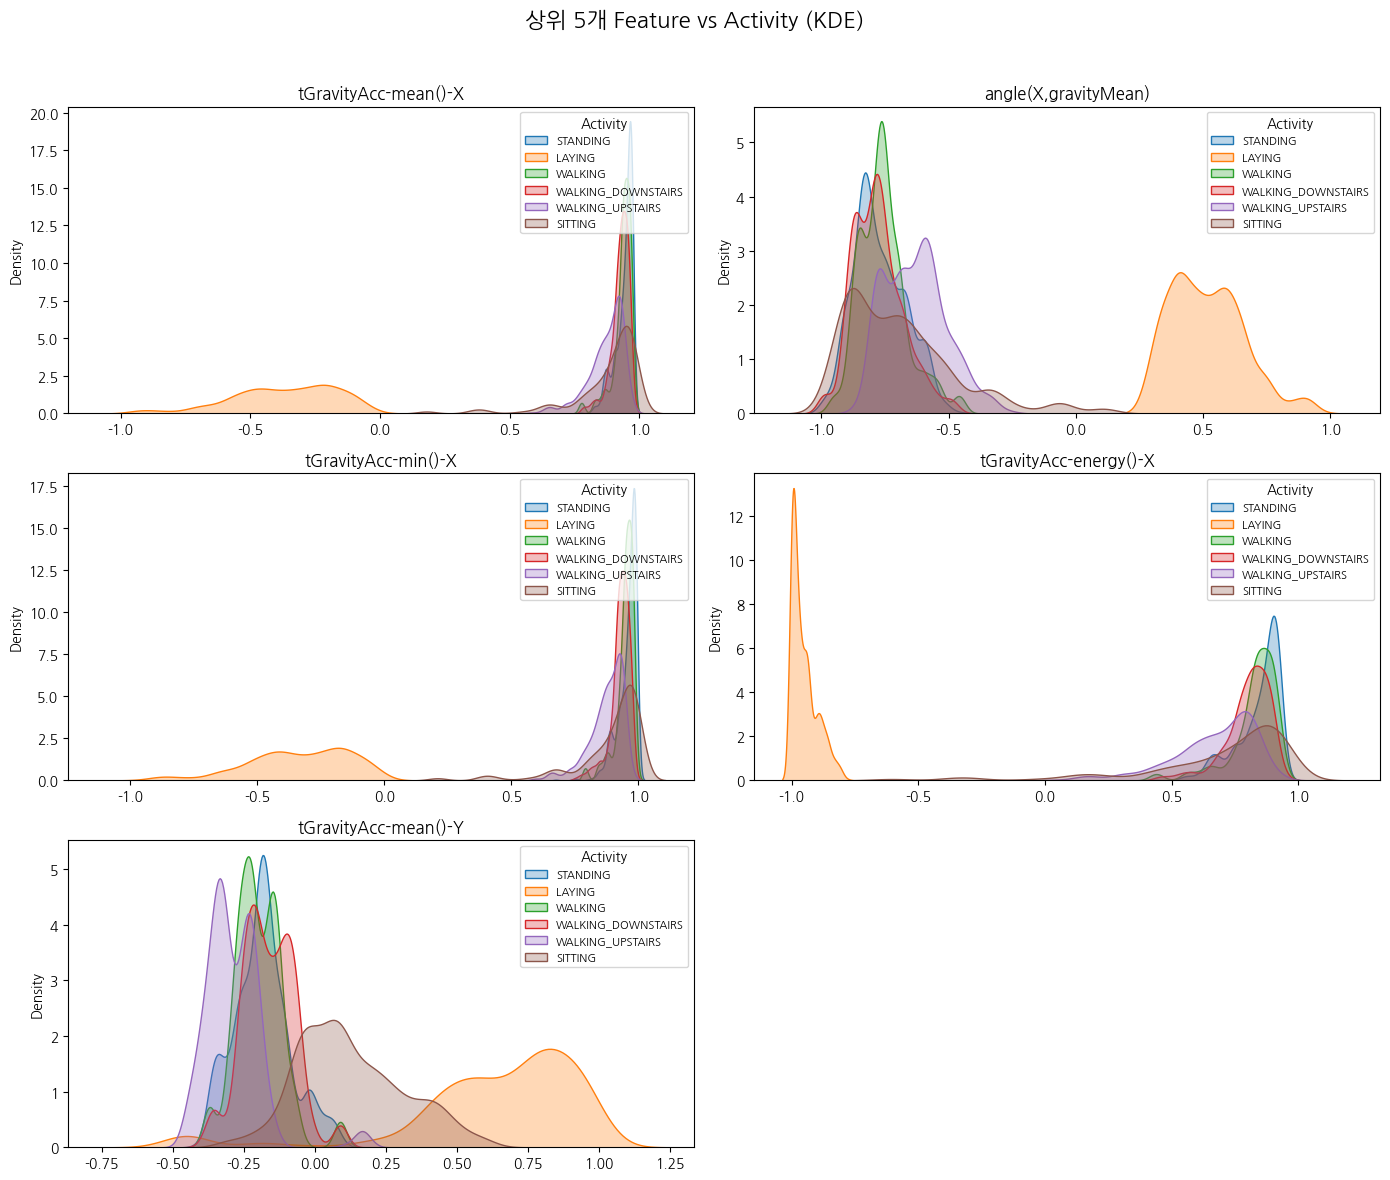

In [ ]:
import math

# 상위 5개
top5_features = [
    "tGravityAcc-mean()-X",
    "angle(X,gravityMean)",
    "tGravityAcc-min()-X",
    "tGravityAcc-energy()-X",
    "tGravityAcc-mean()-Y",
]

# KDE 그리기
n = len(top5_features)
rows=math.ceil(n/2)
cols=2

plt.figure(figsize=(14, 4*rows))
plt.suptitle('상위 5개 Feature vs Activity (KDE)', fontsize=16)

classes = list(train['Activity'].unique())

for i, feat in enumerate(top5_features, 1):
    ax = plt.subplot(rows, cols, i)
    for act in classes:
        subset = train[train["Activity"] == act]
        sns.kdeplot(
            data=subset, x=feat,
            fill=True, alpha=0.3,
            common_norm=False, warn_singular=False,
            label=act
        )
    ax.set_title(feat)
    ax.set_xlabel("")
    ax.set_ylabel("Density")
    ax.legend(title="Activity", fontsize=8, loc="upper right")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

위 그래프는 상위 5개 중요 Feature와 Activity(행동) 간의 관계를 KDE로 시각화한 결과

행동 구분	대표 특징
- LAYING (눕기)	: 대부분 feature에서 분포가 완전히 따로 떨어짐 (−1 부근 or +1 부근)
- STANDING / SITTING : 중간값 근처에서 서로 겹침 (비슷한 정적 자세)
- WALKING / WALKING_UPSTAIRS / WALKING_DOWNSTAIRS	: KDE가 약간 더 퍼져 있음 (움직임이 다양함)

In [ ]:
#1위 : tGravityAcc-mean()-X

In [ ]:
#2위: angle(X,gravityMean)

In [ ]:
#3위: tGravityAcc-min()-X

In [ ]:
#4위: tGravityAcc-energy()-X

In [ ]:
#5위: tGravityAcc-mean()-Y

#### 3) 하위 5개 변수에 대한 분석
        - 위에서 하위 5개의 변수를 선정해서 target과의 관계를 kdeplot으로 그려보세요!

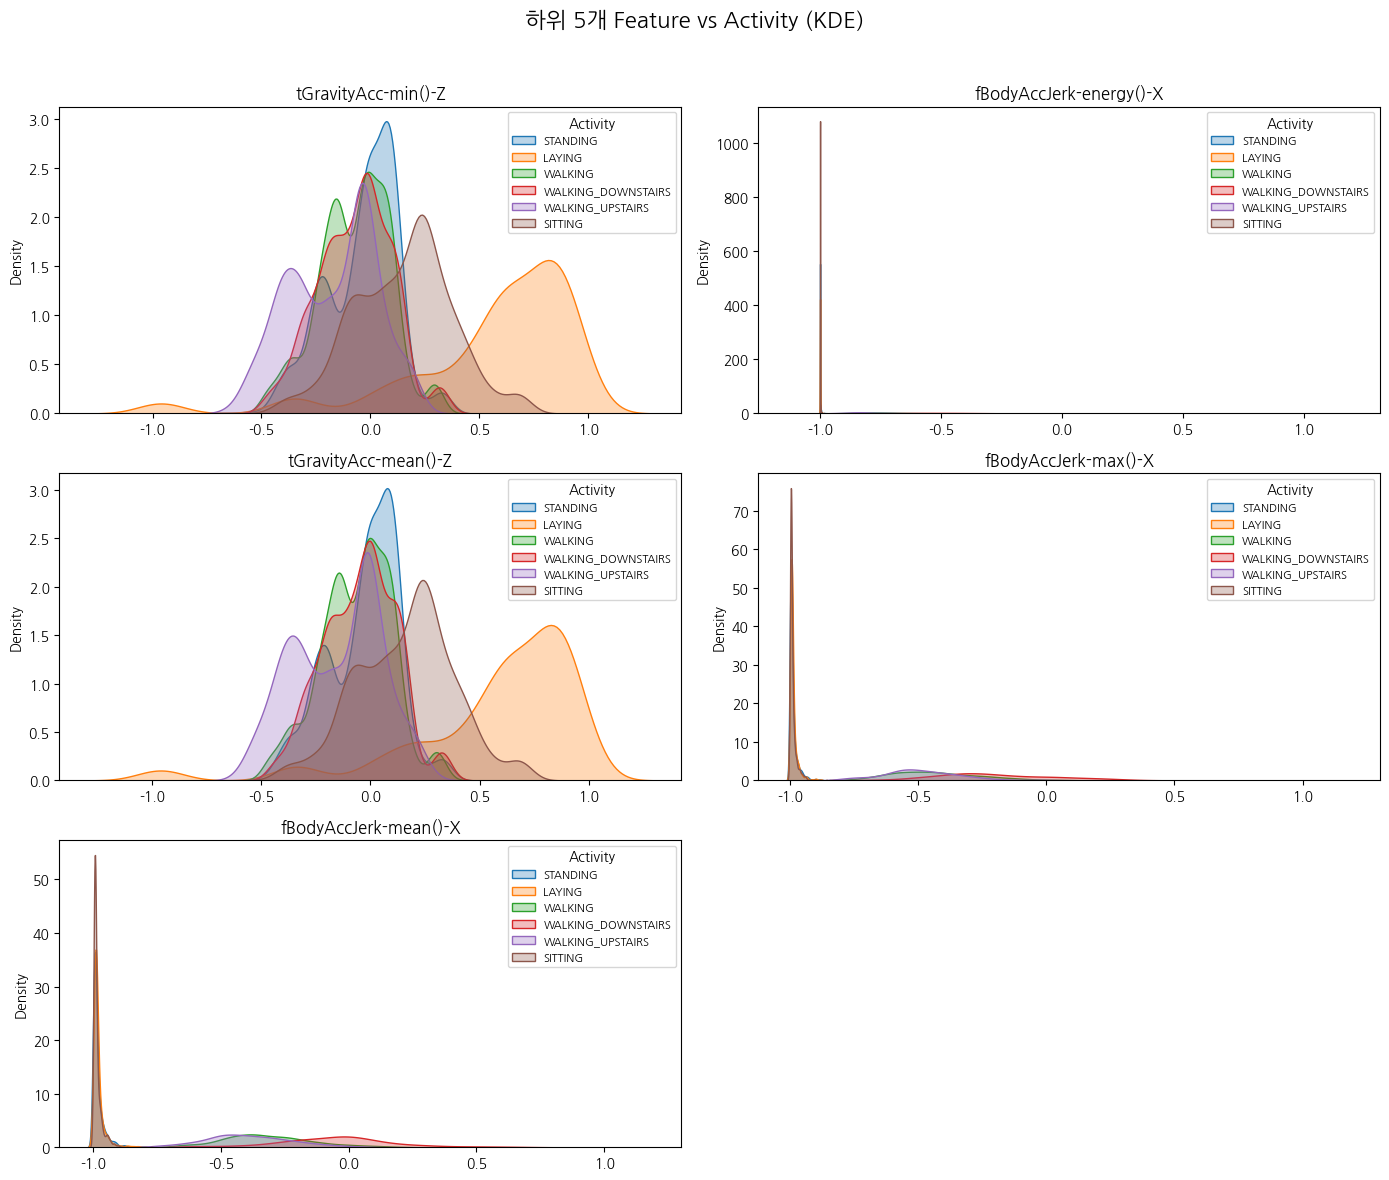

In [ ]:
# 하위 5개
bottom5_features = [
    "tGravityAcc-min()-Z",
    "fBodyAccJerk-energy()-X",
    "tGravityAcc-mean()-Z",
    "fBodyAccJerk-max()-X",
    "fBodyAccJerk-mean()-X",
]

# KDE 시각화
n = len(bottom5_features)
rows = math.ceil(n / 2)
cols = 2

plt.figure(figsize=(14, 4 * rows))
plt.suptitle("하위 5개 Feature vs Activity (KDE)", fontsize=16)

classes = list(train["Activity"].unique())

for i, feat in enumerate(bottom5_features, 1):
    ax = plt.subplot(rows, cols, i)
    for act in classes:
        subset = train[train["Activity"] == act]
        sns.kdeplot(
            data=subset, x=feat,
            fill=True, alpha=0.3,
            common_norm=False, warn_singular=False,
            label=act
        )
    ax.set_title(feat)
    ax.set_xlabel("")
    ax.set_ylabel("Density")
    ax.legend(title="Activity", fontsize=8, loc="upper right")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

위 그래프는 하위 5개 중요 Feature와 Activity(행동) 간의 관계를 KDE로 시각화한 결과

Feature	관찰된 경향	의미
- tGravityAcc-min()-Z	: 모든 Activity가 거의 같은 분포	Z축 중력 최소값은 행동 간 차이를 거의 반영하지 않음
- fBodyAccJerk-energy()-X	: 곡선이 다 겹침	신체가속도의 jerk 에너지(X축)는 클래스 구분 불가
- tGravityAcc-mean()-Z : 살짝 차이는 있으나 대부분 비슷	중력 평균(Z) 방향 변화가 행동별로 거의 일정
- fBodyAccJerk-max()-X	: 일부 행동만 약간 차이	미세한 움직임만 반영함
- fBodyAccJerk-mean()-X	: 거의 동일한 형태	분류에 기여하지 않음

In [ ]:
#1위: tGravityAcc-min()-Z

In [ ]:
#2위: fBodyAccJerk-energy()-X

In [ ]:
#3위: tGravityAcc-mean()-Z

In [ ]:
#4위: fBodyAccJerk-max()-X

In [ ]:
#5위: fBodyAccJerk-mean()-X

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.


#### 1) is_dynamic 추가

In [ ]:
#is dynamic 변수를 추가하세요(값 0, 값 1 확인해서!)
train['is_dynamic'] = train['Activity'].apply(
    lambda x_train: 1 if x_train in ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'] else 0
)

# 확인
print(train['is_dynamic'].value_counts())
print(train[['Activity', 'is_dynamic']].head())

is_dynamic
0    3234
1    2647
Name: count, dtype: int64
             Activity  is_dynamic
0            STANDING           0
1              LAYING           0
2            STANDING           0
3             WALKING           1
4  WALKING_DOWNSTAIRS           1


#### 2) 기본모델 생성

In [ ]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
x = train.drop(['Activity','is_dynamic'], axis=1)
y = train['is_dynamic']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)

In [ ]:
#RandomForestClassifier로 모델링 진행
rf_dynamic = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_dynamic.fit(x_train, y_train)

# 예측 및 정확도 확인
y_pred = rf_dynamic.predict(x_val)
print(accuracy_score(y_val, y_pred))

0.9991503823279524


#### 3) 변수중요도 상위 5개 분석

,feature_name,feature_importance
0,tBodyGyroJerk-iqr()-Z,0.054892
1,fBodyAccJerk-max()-X,0.049978
2,fBodyAccJerk-mean()-X,0.049905
3,tBodyAccJerk-std()-X,0.044888
4,"fBodyAccJerk-bandsEnergy()-1,24",0.040003
5,"fBodyAccJerk-bandsEnergy()-1,16",0.035051
6,fBodyAccJerk-energy()-X,0.035009
7,fBodyAcc-entropy()-X,0.034906
8,tBodyAccJerk-iqr()-X,0.029927
9,fBodyAccJerk-std()-X,0.025188


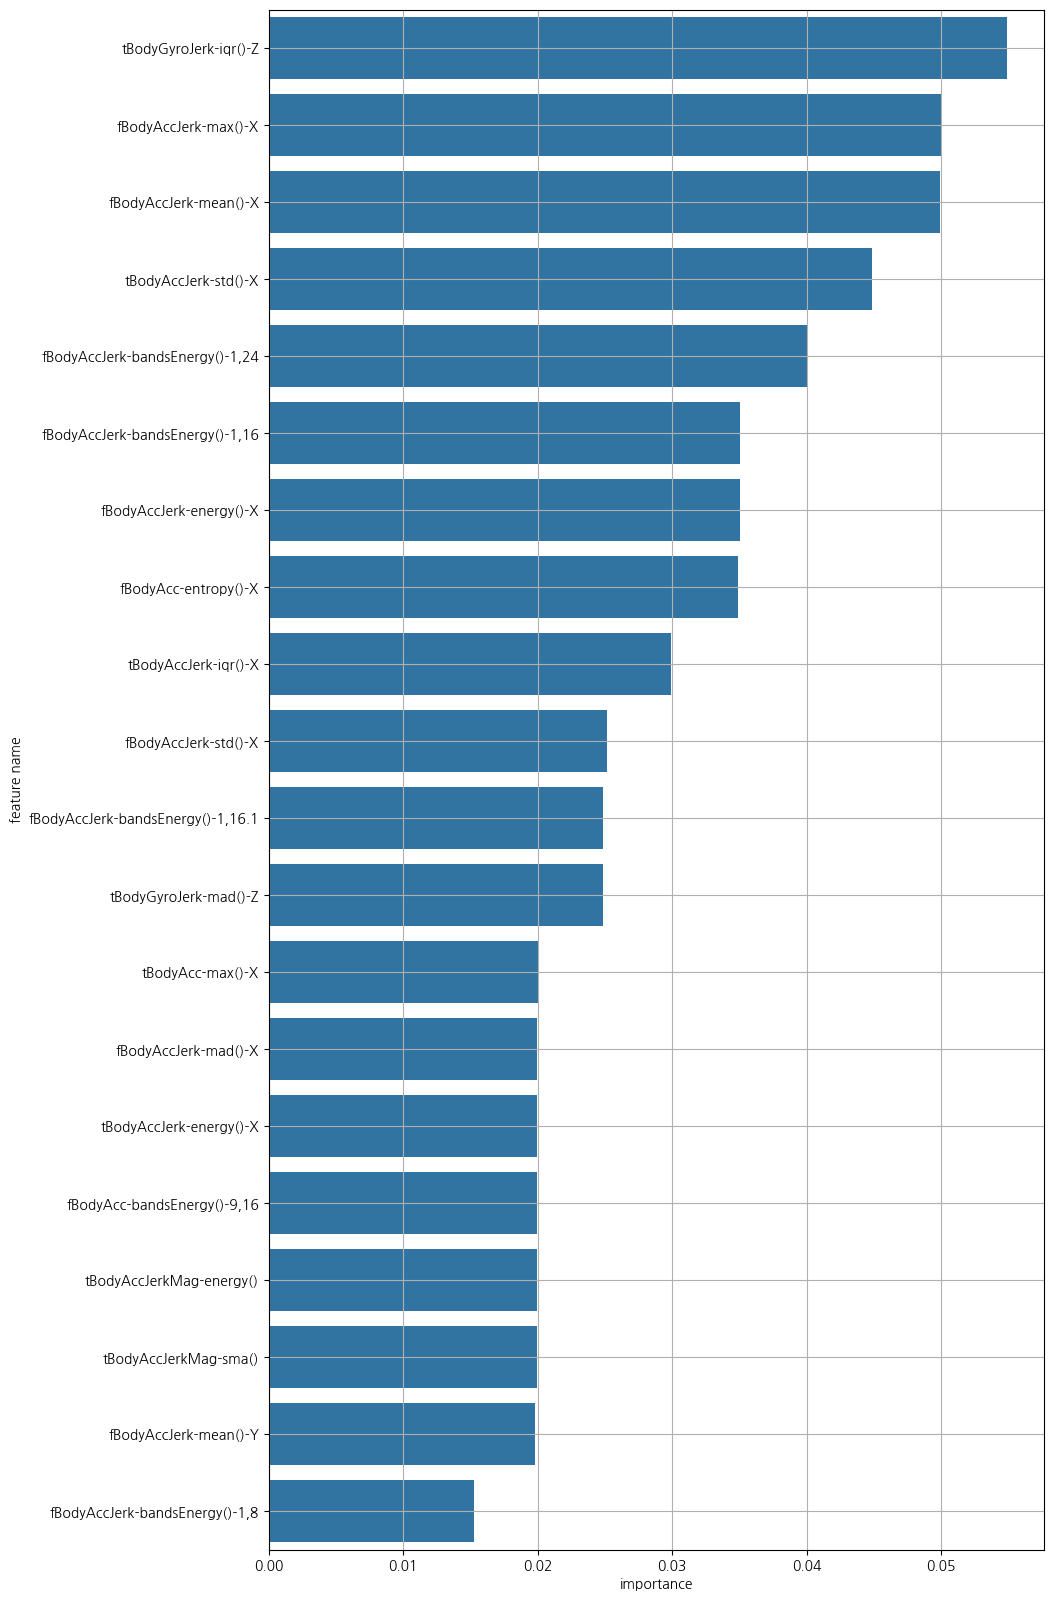

In [ ]:
# is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석!
importances = rf_dynamic.feature_importances_
feature_names = x.columns

fi_dynamic = plot_feature_importance(importances, feature_names, result_only=False, topn=20)
fi_dynamic.head(10)

* 미션1에서 했던 것 처럼 상위 5개의 변수 데이터를 탐색해보기!

In [ ]:
#1위:tBodyGyroJerk-iqr()-Z

In [ ]:
#2위:fBodyAccJerk-max()-X

In [ ]:
#3위:fBodyAccJerk-mean()-X

In [ ]:
#4위:tBodyAccJerk-std()-X

In [ ]:
#5위:fBodyAccJerk-bandsEnergy()-1,24

## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

#### 1) 이름변경

In [ ]:
# tip : rename을 써서 칼럼 이름 수정을 해야합니다!
# 6개의 행동 구분(feature importance)
fi_df.rename(columns={'feature_importance': 'importance_6class'}, inplace=True)

# 정적/동적 구분(feature importance)
fi_dynamic.rename(columns={'feature_importance': 'importance_dynamic'}, inplace=True)

#### 2) 합치기

In [ ]:
# merge 해서 2개를 합치는 작업하기
merged_fi = pd.merge(fi_df, fi_dynamic, on='feature_name', how='outer')

In [ ]:
# 결측값 처리 (어느 한쪽에만 존재하는 feature 처리)
merged_fi.fillna(0, inplace=True)

# 중요도 평균(두 관점 통합)
merged_fi['importance_mean'] = (merged_fi['importance_6class'] + merged_fi['importance_dynamic']) / 2

merged_fi.sort_values(by='importance_mean', ascending=False).head(10)

,feature_name,importance_6class,importance_dynamic,importance_mean
12,fBodyAccJerk-max()-X,0.009229,0.049978,0.029603
13,fBodyAccJerk-mean()-X,0.009220,0.049905,0.029563
23,tBodyGyroJerk-iqr()-Z,0.000000,0.054892,0.027446
6,"fBodyAccJerk-bandsEnergy()-1,16",0.010641,0.035051,0.022846
20,tBodyAccJerk-std()-X,0.000000,0.044888,0.022444
10,fBodyAccJerk-energy()-X,0.009386,0.035009,0.022197
8,"fBodyAccJerk-bandsEnergy()-1,24",0.000000,0.040003,0.020001
4,fBodyAcc-entropy()-X,0.000000,0.034906,0.017453
30,tGravityAcc-mean()-X,0.033055,0.000000,0.016528
19,tBodyAccJerk-iqr()-X,0.000000,0.029927,0.014964


In [ ]:
merged_fi.head()

,feature_name,importance_6class,importance_dynamic,importance_mean
0,"angle(X,gravityMean)",0.029547,0.000000,0.014774
1,"angle(Y,gravityMean)",0.019872,0.000000,0.009936
2,"angle(Z,gravityMean)",0.010565,0.000000,0.005283
3,"fBodyAcc-bandsEnergy()-9,16",0.000000,0.019957,0.009979
4,fBodyAcc-entropy()-X,0.000000,0.034906,0.017453


In [ ]:
# features.csv와 합치기

# feature 이름 구조 정보 불러오기
features_info = pd.read_csv('features.csv')

# feature 이름 기준으로 병합
final_fi = pd.merge(merged_fi, features_info, left_on='feature_name', right_on='feature_name', how='left')

# 불필요한 중복 컬럼 제거
final_fi.drop(columns=['feature'], inplace=True, errors='ignore')

# 최종 확인
final_fi.head()

,feature_name,importance_6class,importance_dynamic,importance_mean,sensor,agg,axis
0,"angle(X,gravityMean)",0.029547,0.000000,0.014774,angle,X,gravityMean
1,"angle(Y,gravityMean)",0.019872,0.000000,0.009936,angle,Y,gravityMean
2,"angle(Z,gravityMean)",0.010565,0.000000,0.005283,angle,Z,gravityMean
3,"fBodyAcc-bandsEnergy()-9,16",0.000000,0.019957,0.009979,fBodyAcc,bandsEnergy(),"9,16"
4,fBodyAcc-entropy()-X,0.000000,0.034906,0.017453,fBodyAcc,entropy(),X


### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
# joblib.dump 이용해서 colab에 .pkl 파일에 저장하기(tip: path + '파일 이름.pkl')
from joblib import dump

# colab 환경에서는 보통 content/drive/MyDrive/ 같은 경로에 저장 가능
dump(final_fi, path + 'feature_importance_all.pkl')

['/content/drive/MyDrive/project2/feature_importance_all.pkl']

#### 고생하셨습니다! 이제 기본 모델링을 해봅시다.